In [ ]:
# For the 'InstanceNormalization' layer
!pip install --upgrade tensorflow_addons
# For the dataset
!pip install --upgrade tensorflow_datasets

Requirement already up-to-date: tensorflow_addons in /usr/local/lib/python3.6/dist-packages (0.6.0)
Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (1.3.2)


In [ ]:
#IMPORTING THE REQUIRED LIBRARIES

import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import (Activation, Concatenate, Conv2D,
                                     Conv2DTranspose, Input, LeakyReLU)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.layers import InstanceNormalization

import tensorflow_datasets as tfds

%matplotlib inline

In [ ]:
# Load dataset
# We used the monet2photo dataset reversely, so that it can turn the photos into monet images
data, metadata = tfds.load('cycle_gan/monet2photo', with_info=True, as_supervised=True)

#splitting the dataset into train/test
train_x, train_y, test_x, test_y = data['trainB'], data['trainA'], data['testB'], data['testA']

In [ ]:
# Settings
epochs = 50
# We trained the model with the 50 epochs
LAMBDA = 10

img_rows, img_cols, channels = 256, 256, 3
# We used 256 x 256 images, and since it is colourfull there are 3 channels
weight_initializer = RandomNormal(stddev=0.02)

# The learning rate is 0.002
gen_g_optimizer = gen_f_optimizer = Adam(lr=0.002, beta_1=0.5)
dis_x_optimizer = dis_y_optimizer = Adam(lr=0.002, beta_1=0.5)

In [ ]:
# Normalize images to [-1, 1] and reshape
def preprocess_image(image,_):
    return tf.reshape(tf.cast(tf.image.resize(image, (int(img_rows), int(img_cols))), tf.float32) / 127.5 - 1, (1, img_rows, img_cols, channels))

In [ ]:
# Map the normalization onto the dataset
train_x = train_x.map(preprocess_image)
train_y = train_y.map(preprocess_image)
test_x = test_x.map(preprocess_image)
test_y = test_y.map(preprocess_image)

In [ ]:
# Normalization +ReLu

def Ck(input, k, use_instancenorm=True):
    block = Conv2D(k, (4, 4), strides=2, padding='same', kernel_initializer=weight_initializer)(input)
    if use_instancenorm:
        block = InstanceNormalization(axis=-1)(block)
    block = LeakyReLU(0.2)(block)

    return block
    
#Coding the discriminator
def discriminator():
    dis_input = Input(shape=(img_rows, img_cols, channels))

    d = Ck(dis_input, 64, False)
    d = Ck(d, 128)
    d = Ck(d, 256)
    d = Ck(d, 512)

    d = Conv2D(1, (4, 4), padding='same', kernel_initializer=weight_initializer)(d)

    return Model(dis_input, d)

In [ ]:

# Convolution+ Normalization + ReLu  
def dk(k, use_instancenorm=True):
    block = Sequential()
    block.add(Conv2D(k, (3, 3), strides=2, padding='same', kernel_initializer=weight_initializer))
    if use_instancenorm:
        block.add(InstanceNormalization(axis=-1))
    block.add(Activation('relu'))

    return block

def uk(k):
    block = Sequential()
    block.add(Conv2DTranspose(k, (3, 3), strides=2, padding='same', kernel_initializer=weight_initializer))
    block.add(InstanceNormalization(axis=-1))
    block.add(Activation('relu'))

    return block

# Coding the generator

def generator():
    gen_input = Input(shape=(img_rows, img_cols, channels))
    
    # Layers for the encoder part of the model
    encoder_layers = [
        dk(64, False),
        dk(128),
        dk(256),
        dk(512),
        dk(512),
        dk(512),
        dk(512),
        dk(512)
    ]

    # Layers for the decoder part of the model
    decoder_layers = [
        uk(512),
        uk(512),
        uk(512),
        uk(512),
        uk(256),
        uk(128),
        uk(64)
    ]

    gen = gen_input

    # Add all the encoder layers, and keep track of them for skip connections
    
    skips = []
    for layer in encoder_layers:
        gen = layer(gen)
        skips.append(gen)
    
    skips = skips[::-1][1:] 
    
    # Reverse for looping and get rid of the layer that directly connects to decoder

    # Add all the decoder layers and skip connections
    for skip_layer, layer in zip(skips, decoder_layers):
        gen = layer(gen)
        gen = Concatenate()([gen, skip_layer])

    
    # Final layer
    gen = Conv2DTranspose(channels, (3, 3), strides=2, padding='same', kernel_initializer=weight_initializer, activation='tanh')(gen)
    
    # Compose model
    return Model(gen_input, gen)



In [ ]:
# Define the models
generator_g = generator()
generator_f = generator()

discriminator_x = discriminator()
discriminator_y = discriminator()


In [ ]:
# Losses
loss = BinaryCrossentropy(from_logits=True)

# Measures how close to one real images are rated, and how close to zero fake images are rated
def discriminator_loss(real, generated):
    # Multiplied by 0.5 so that it will train at half-speed
    return (loss(tf.ones_like(real), real) + loss(tf.zeros_like(generated), generated)) * 0.5

# Measures how real the discriminator believes the fake image is
def gen_loss(validity):
    return loss(tf.ones_like(validity), validity)

# Measures similarity of two images.  Used for cycle and identity loss
def image_similarity(image1, image2):
    return tf.reduce_mean(tf.abs(image1 - image2))

In [ ]:
@tf.function
def step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Setup Dy loss
        fake_y = generator_g(real_x, training=True)
        gen_g_validity = discriminator_y(fake_y, training=True)
        dis_y_loss = discriminator_loss(discriminator_y(real_y, training=True), gen_g_validity)

        with tape.stop_recording():
            discriminator_y_gradients = tape.gradient(dis_y_loss, discriminator_y.trainable_variables)
            dis_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

        # Setup Dx loss
        fake_x = generator_f(real_y, training=True)
        gen_f_validity = discriminator_x(fake_x, training=True)
        dis_x_loss = discriminator_loss(discriminator_x(real_x, training=True), gen_f_validity)

        with tape.stop_recording():
            discriminator_x_gradients = tape.gradient(dis_x_loss, discriminator_x.trainable_variables)
            dis_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))

        # Setup adversarial losses
        gen_g_adv_loss = gen_loss(gen_g_validity)
        gen_f_adv_loss = gen_loss(gen_f_validity)

        # Setup cycle losses
        cyc_x = generator_f(fake_y, training=True)
        cyc_x_loss = image_similarity(real_x, cyc_x)

        cyc_y = generator_g(fake_x, training=True)
        cyc_y_loss =  image_similarity(real_y, cyc_y)

        # Setup identity losses
        id_x = generator_f(real_x, training=True)
        id_x_loss = image_similarity(real_x, id_x)

        id_y = generator_g(real_y, training=True)
        id_y_loss = image_similarity(real_y, id_y)

        # Finalize generator losses and calc gradients
        gen_g_loss = gen_g_adv_loss + (cyc_x_loss + cyc_y_loss) * LAMBDA + id_y_loss * 0.5*LAMBDA
        gen_f_loss = gen_f_adv_loss + (cyc_x_loss + cyc_y_loss) * LAMBDA + id_x_loss * 0.5*LAMBDA

        with tape.stop_recording():
            generator_g_gradients = tape.gradient(gen_g_loss, generator_g.trainable_variables)
            gen_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))

            generator_f_gradients = tape.gradient(gen_f_loss, generator_f.trainable_variables)
            gen_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

In [ ]:
def generate_images():
    # Sample images
    x = next(iter(test_x.shuffle(1000))).numpy()
    y = next(iter(test_y.shuffle(1000))).numpy()
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(12, 12))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Manually loop through epochs
for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    start = time.time()

    # Each batch
    for k, (real_x, real_y) in enumerate(tf.data.Dataset.zip((train_x, train_y))):
        if k % 100 == 0: print(k)
        # Train step
        step(tf.reshape(real_x, (1, img_rows, img_cols, channels)), tf.reshape(real_y, (1, img_rows, img_cols, channels)))
    
    # View progress
    generate_images()
    print('Time taken: {}'.format(time.time() - start))

In [ ]:
!git clone https://github.com/rabia174/data2.git

Cloning into 'data2'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [ ]:
%cd data2

/content/data2/data2


In [ ]:
from PIL import Image
from numpy import*
from skimage import io, transform 
import os

def generate_images2():
    
    x= io.imread('qq.png')/256.5-1
    x = np.array(x)
    
    y = io.imread('qq.png')/256.5-1
    y = np.array(y)
    
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(12, 12))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

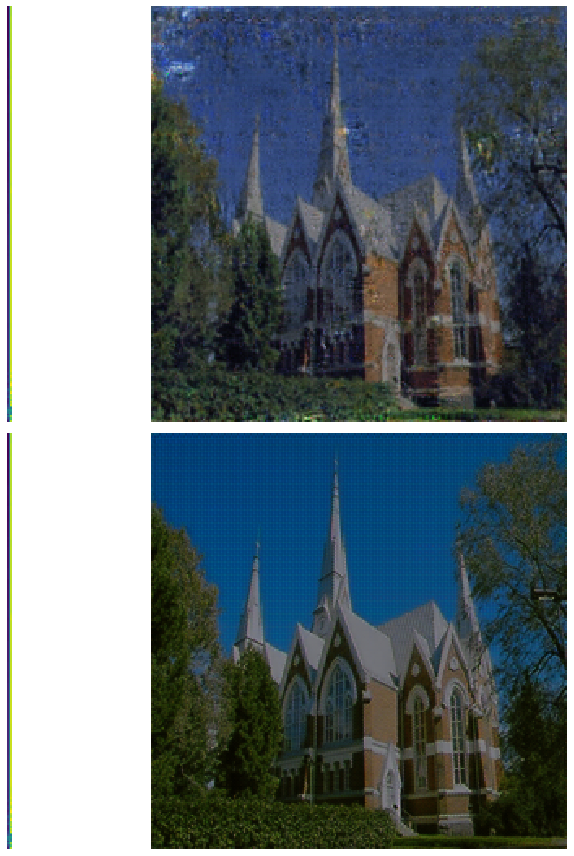

In [ ]:
generate_images2()

In [ ]:
!git clone https://github.com/rabia174/data3.git

Cloning into 'data3'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 22 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [ ]:
%cd data3/

/root/data3


In [ ]:
!ls

'Joensuu  (10).png'  'Joensuu  (17).png'  'Joensuu  (4).png'
'Joensuu  (11).png'  'Joensuu (18).png'   'Joensuu  (5).png'
'Joensuu  (12).png'  'Joensuu  (19).png'  'Joensuu  (6).png'
'Joensuu  (13).png'  'Joensuu  (1).png'   'Joensuu  (7).png'
'Joensuu  (14).png'  'Joensuu (20).png'   'Joensuu  (8).png'
'Joensuu  (15).png'  'Joensuu  (2).png'   'Joensuu  (9).png'
'Joensuu  (16).png'  'Joensuu  (3).png'


In [ ]:
from PIL import Image
from numpy import*
from skimage import io, transform 
import os


def generate_images3():
    
    x= io.imread('Joensuu  (1).png')/256.5-1
    x = np.array(x)
    
    y = io.imread('Joensuu  (1).png')/256.5-1
    y = np.array(y)
    
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(12, 12))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

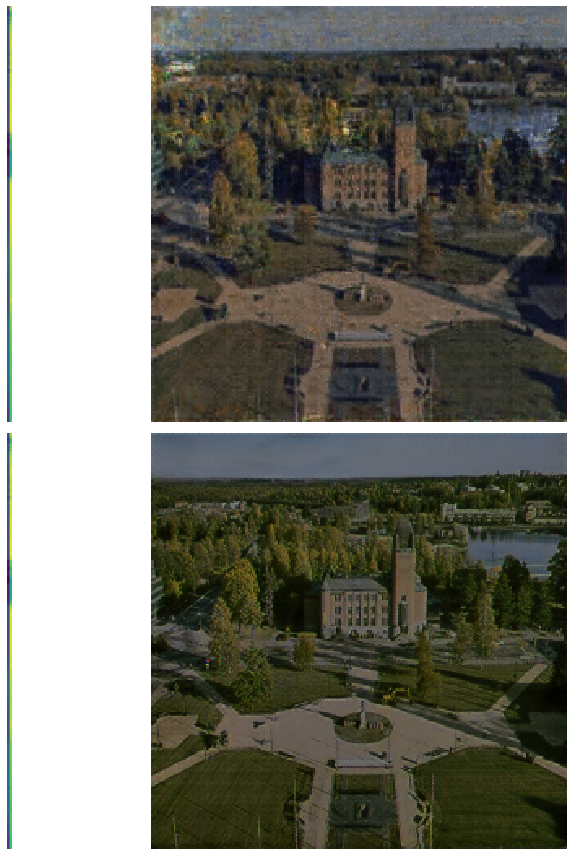

In [ ]:
generate_images3()

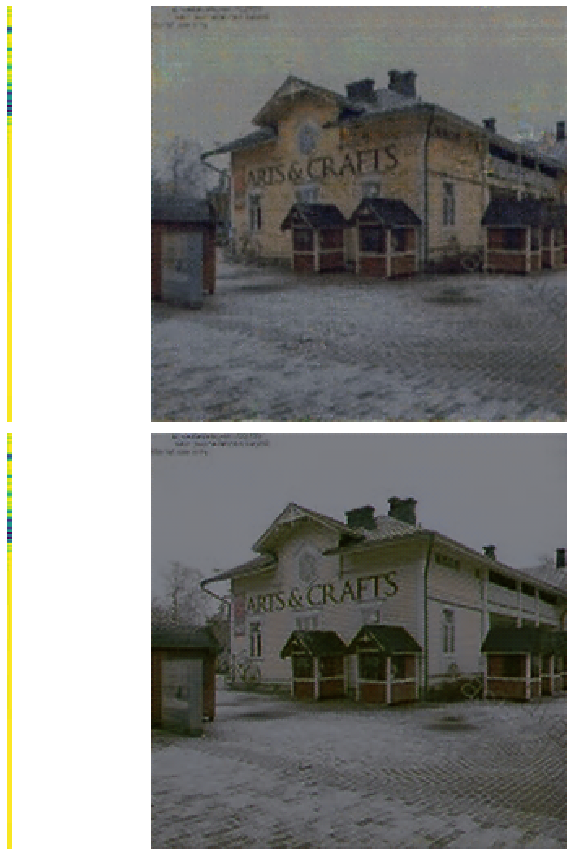

In [ ]:
from PIL import Image
from numpy import*
from skimage import io, transform 
import os


def generate_images4():
  
    
    x= io.imread('Joensuu  (2).png')/256.5-1
    x = np.array(x)
    
    y = io.imread('Joensuu  (2).png')/256.5-1
    y = np.array(y)
    
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(12, 12))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_images4()

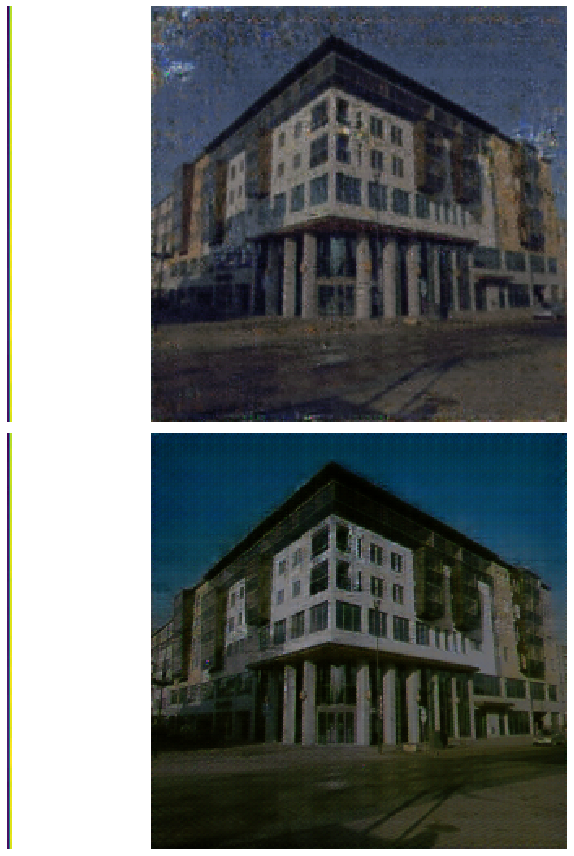

In [ ]:
from PIL import Image
from numpy import*
from skimage import io, transform 
import os


def generate_images5():
  
    
    x= io.imread('Joensuu  (3).png')/256.5-1
    x = np.array(x)
    
    y = io.imread('Joensuu  (3).png')/256.5-1
    y = np.array(y)
    
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(12, 12))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_images5()

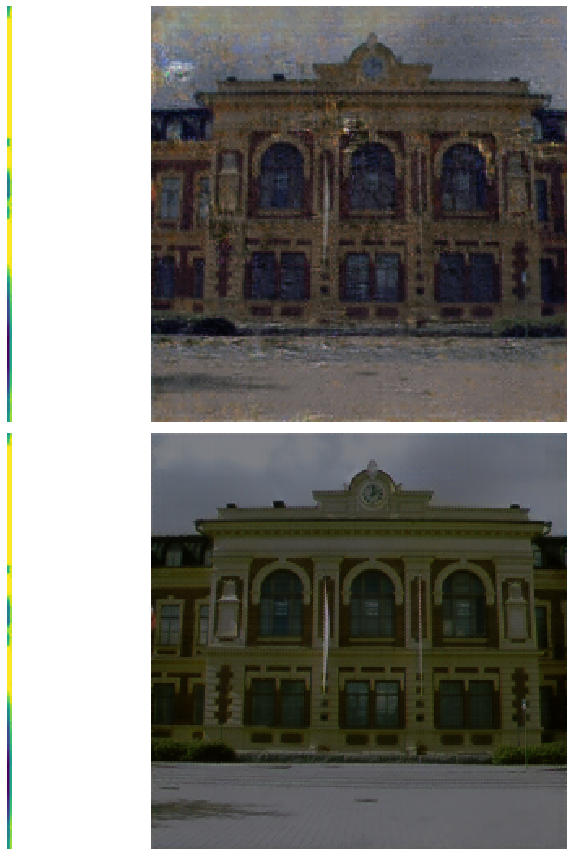

In [ ]:
from PIL import Image
from numpy import*
from skimage import io, transform 
import os


def generate_images5():
  
    
    x= io.imread('Joensuu  (15).png')/256.5-1
    x = np.array(x)
    
    y = io.imread('Joensuu  (15).png')/256.5-1
    y = np.array(y)
    
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(12, 12))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_images5()

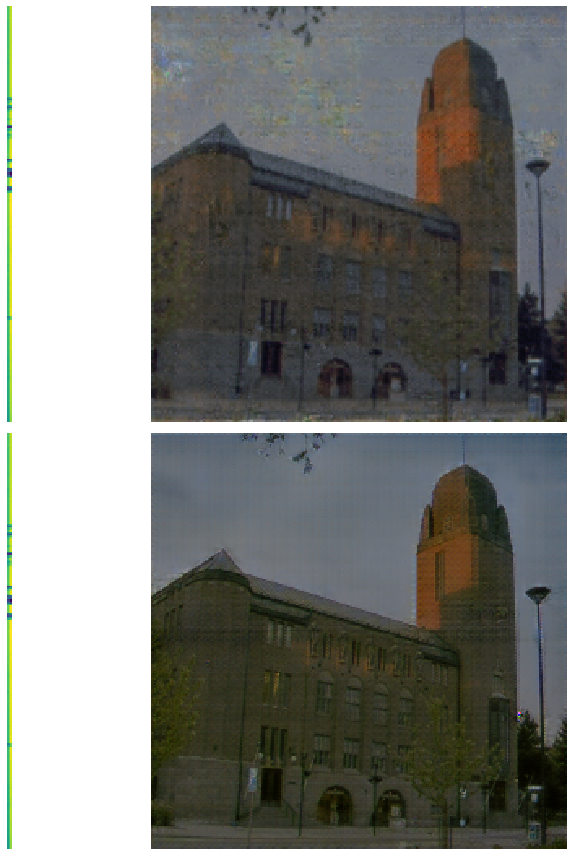

In [ ]:
from PIL import Image
from numpy import*
from skimage import io, transform 
import os


def generate_images6():
  
    
    x= io.imread('Joensuu  (10).png')/256.5-1
    x = np.array(x)
    
    y = io.imread('Joensuu  (10).png')/256.5-1
    y = np.array(y)
    
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(12, 12))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_images6()

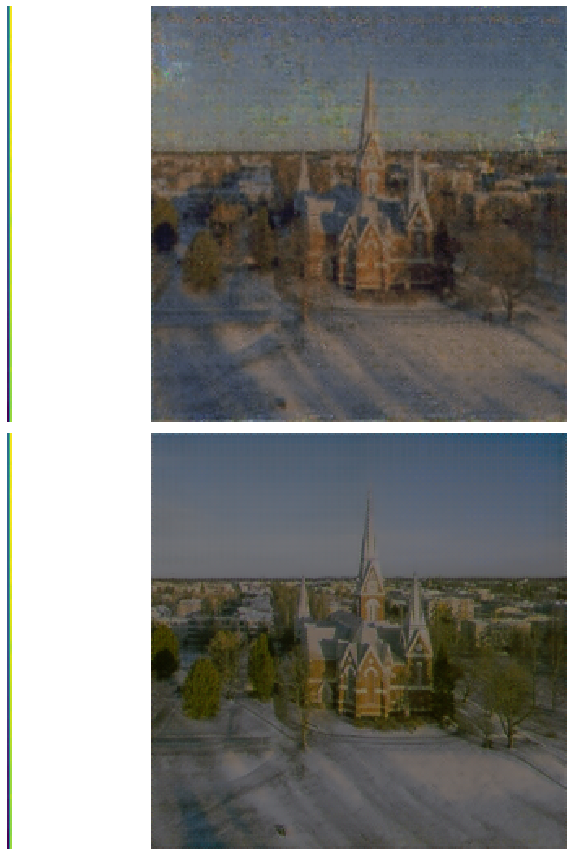

In [ ]:
from PIL import Image
from numpy import*
from skimage import io, transform 
import os


def generate_images7():
  
    
    x= io.imread('Joensuu  (7).png')/256.5-1
    x = np.array(x)
    
    y = io.imread('Joensuu  (7).png')/256.5-1
    y = np.array(y)
    
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(12, 12))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_images7()

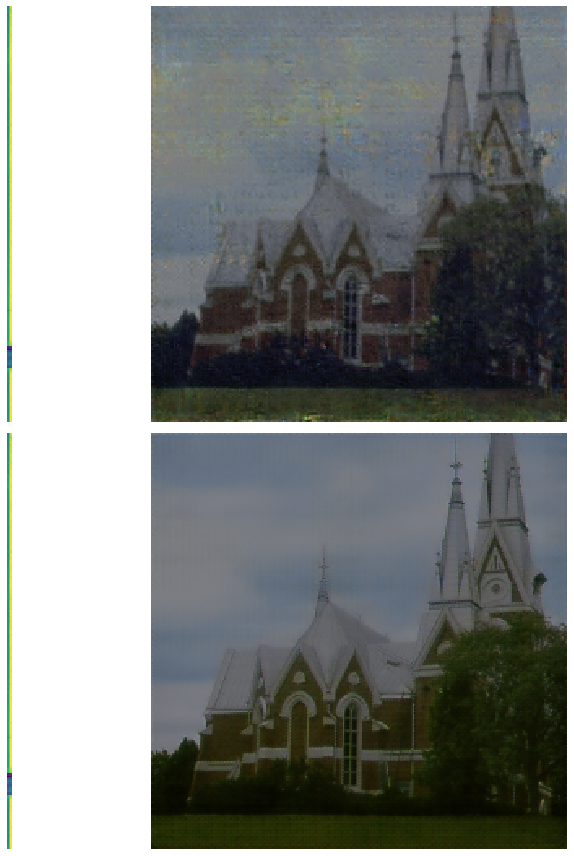

In [ ]:
from PIL import Image
from numpy import*
from skimage import io, transform 
import os


def generate_images11():
  
    
    x= io.imread('Joensuu  (11).png')/256.5-1
    x = np.array(x)
    
    y = io.imread('Joensuu  (11).png')/256.5-1
    y = np.array(y)
    
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(12, 12))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_images11()

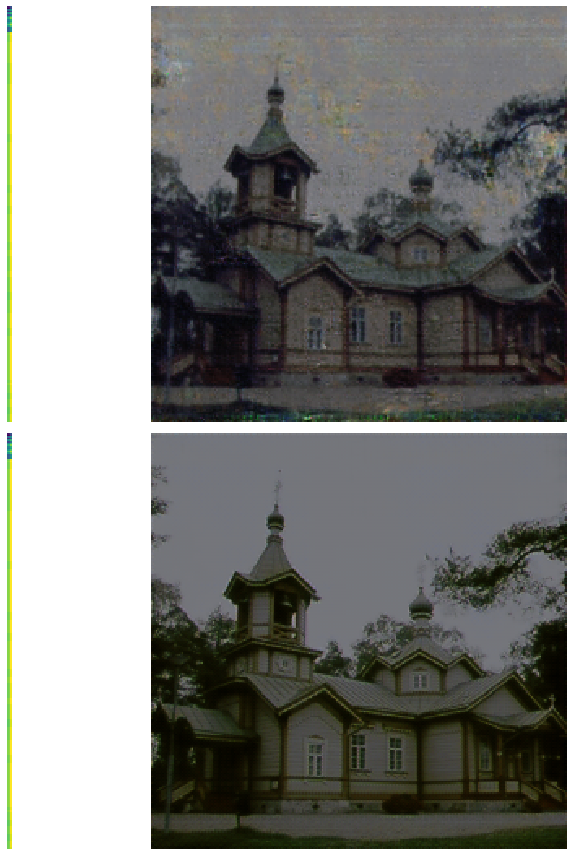

In [ ]:
from PIL import Image
from numpy import*
from skimage import io, transform 
import os


def generate_images16():
  
    
    x= io.imread('Joensuu  (16).png')/256.5-1
    x = np.array(x)
    
    y = io.imread('Joensuu  (16).png')/256.5-1
    y = np.array(y)
    
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(12, 12))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_images16()

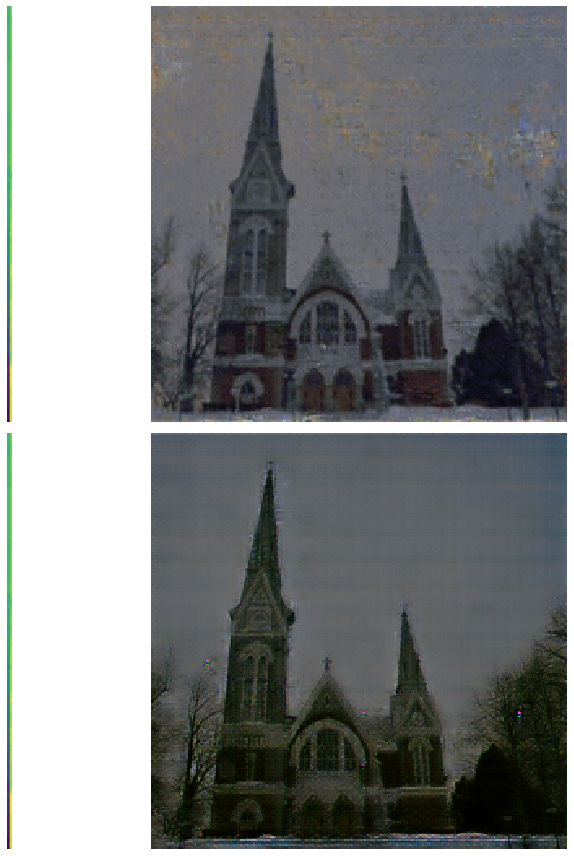

In [ ]:
from PIL import Image
from numpy import*
from skimage import io, transform 
import os


def generate_images12():
  
    
    x= io.imread('Joensuu  (12).png')/256.5-1
    x = np.array(x)
    
    y = io.imread('Joensuu  (12).png')/256.5-1
    y = np.array(y)
    
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(12, 12))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_images12()

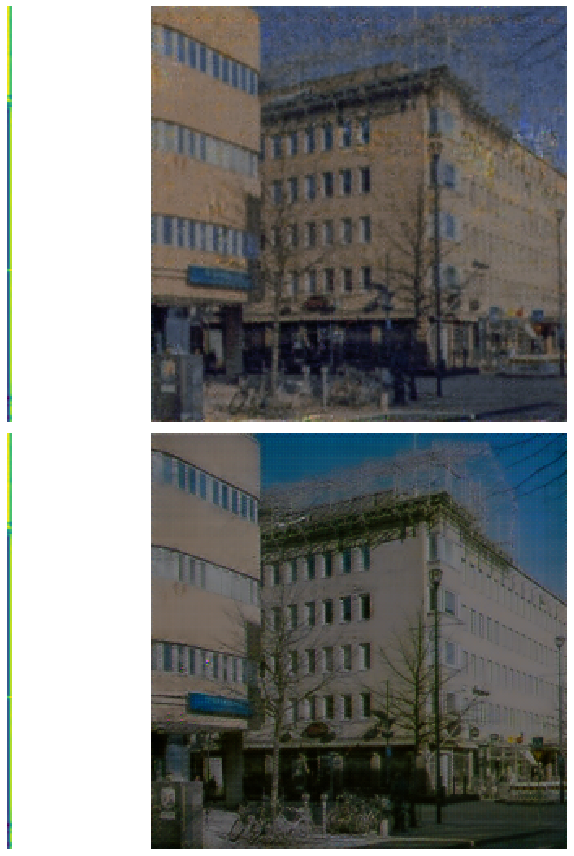

In [ ]:
from PIL import Image
from numpy import*
from skimage import io, transform 
import os


def generate_images19():
  
    
    x= io.imread('Joensuu  (19).png')/256.5-1
    x = np.array(x)
    
    y = io.imread('Joensuu  (19).png')/256.5-1
    y = np.array(y)
    
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(12, 12))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_images19()

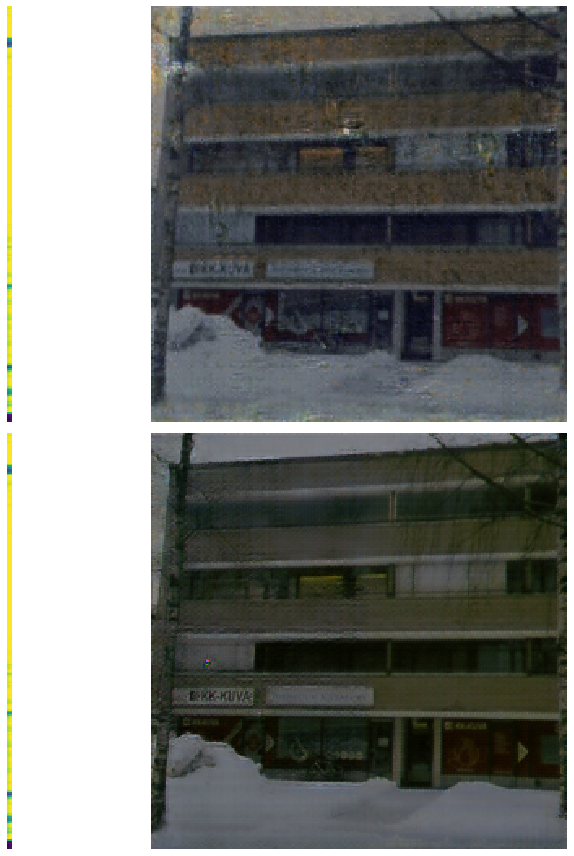

In [ ]:
from PIL import Image
from numpy import*
from skimage import io, transform 
import os


def generate_images13():
  
    
    x= io.imread('Joensuu  (13).png')/256.5-1
    x = np.array(x)
    
    y = io.imread('Joensuu  (13).png')/256.5-1
    y = np.array(y)
    
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(12, 12))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_images13()

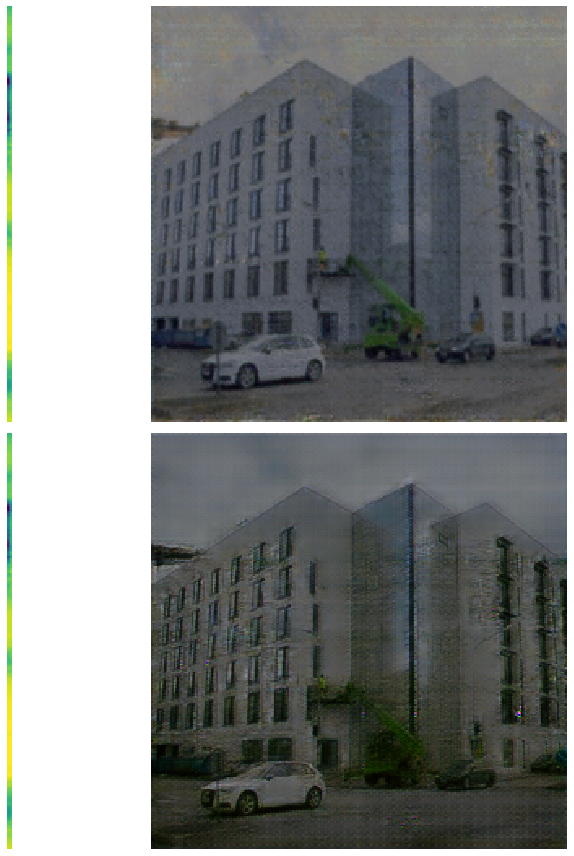

In [ ]:
from PIL import Image
from numpy import*
from skimage import io, transform 
import os


def generate_images18():
  
    
    x= io.imread('Joensuu (18).png')/256.5-1
    x = np.array(x)
    
    y = io.imread('Joensuu (18).png')/256.5-1
    y = np.array(y)
    
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(12, 12))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_images18()

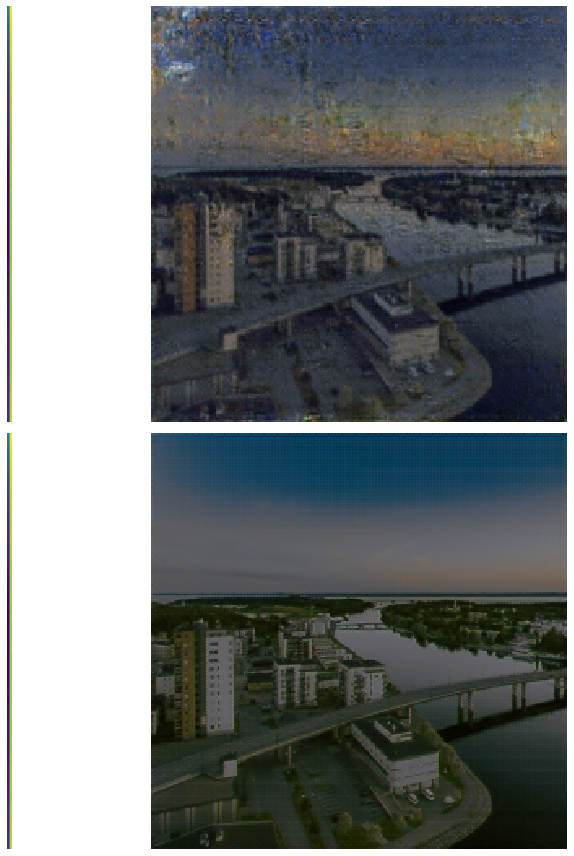

In [ ]:
from PIL import Image
from numpy import*
from skimage import io, transform 
import os


def generate_images8():
  
    
    x= io.imread('Joensuu  (8).png')/256.5-1
    x = np.array(x)
    
    y = io.imread('Joensuu  (8).png')/256.5-1
    y = np.array(y)
    
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(12, 12))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_images8()

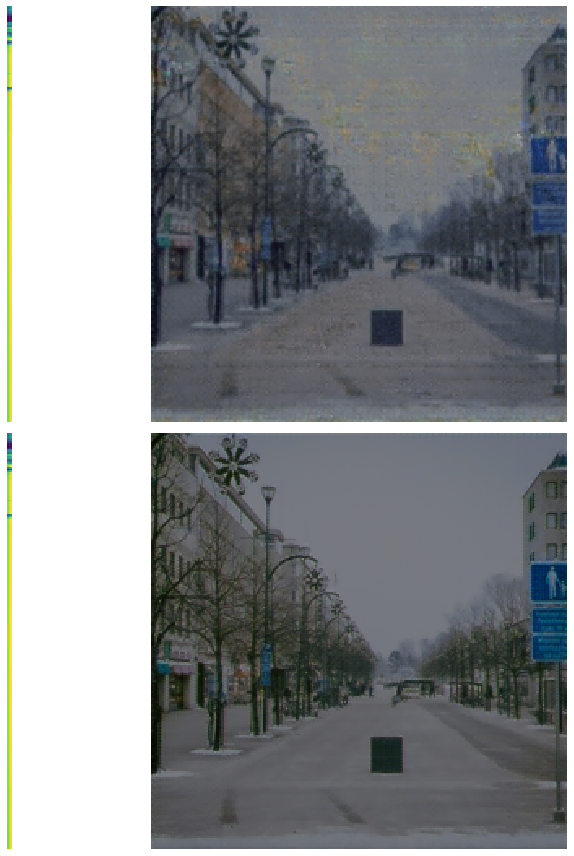

In [ ]:
from PIL import Image
from numpy import*
from skimage import io, transform 
import os


def generate_images4():
  
    
    x= io.imread('Joensuu  (4).png')/256.5-1
    x = np.array(x)
    
    y = io.imread('Joensuu  (4).png')/256.5-1
    y = np.array(y)
    
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(12, 12))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_images4()

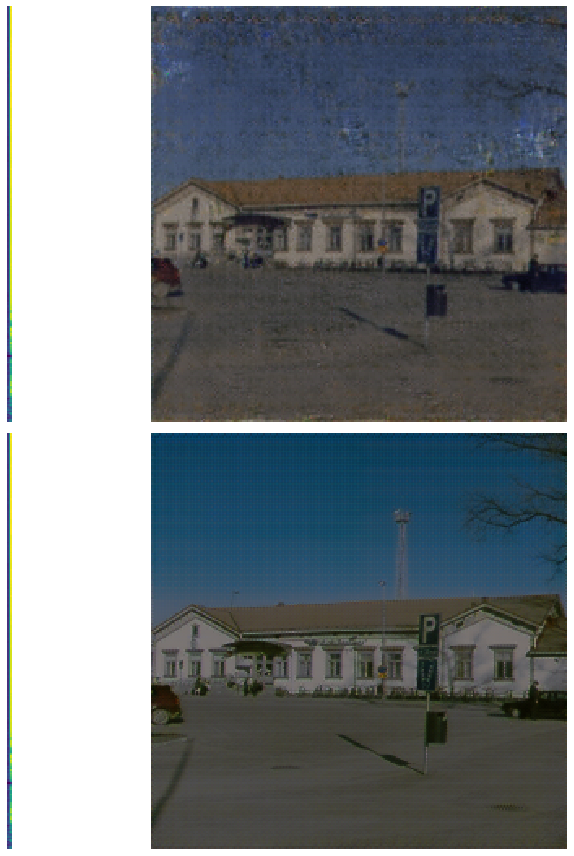

In [ ]:
from PIL import Image
from numpy import*
from skimage import io, transform 
import os


def generate_images9():
  
    
    x= io.imread('Joensuu  (9).png')/256.5-1
    x = np.array(x)
    
    y = io.imread('Joensuu  (9).png')/256.5-1
    y = np.array(y)
    
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(12, 12))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_images9()

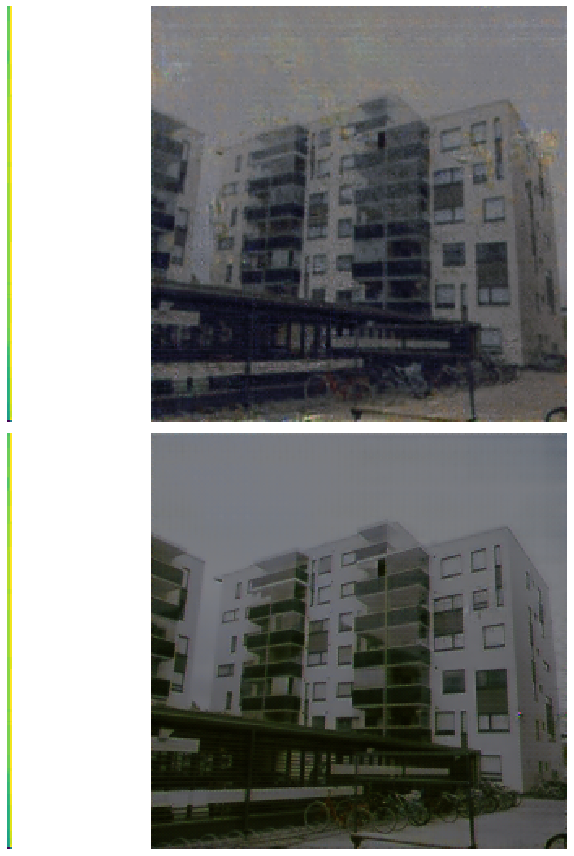

In [ ]:
from PIL import Image
from numpy import*
from skimage import io, transform 
import os


def generate_images20():
  
    
    x= io.imread('Joensuu (20).png')/256.5-1
    x = np.array(x)
    
    y = io.imread('Joensuu (20).png')/256.5-1
    y = np.array(y)
    
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(12, 12))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_images20()

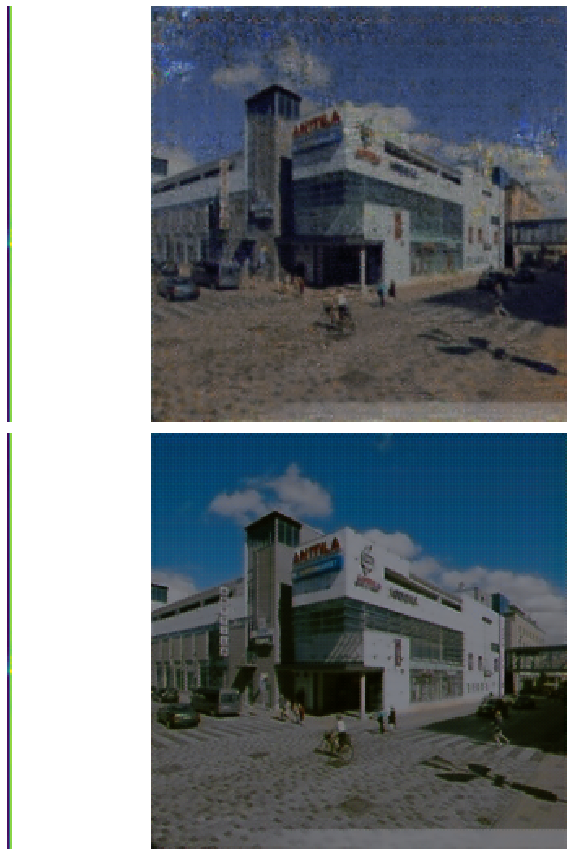

In [ ]:
from PIL import Image
from numpy import*
from skimage import io, transform 
import os


def generate_images45():
  
    
    x= io.imread('Joensuu  (5).png')/256.5-1
    x = np.array(x)
    
    y = io.imread('Joensuu  (5).png')/256.5-1
    y = np.array(y)
    
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(12, 12))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_images45()